## Interface height vs layer thickness gradients

In models with large scale bottom slope changes the bottom layer thickness ends up incorporating this information in it. While this bottom slope probably impacts the eddy fluxes, it does not seem to be the case that this has a first order effect. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
# import yaml
# with open('DG_exp_config.yml', 'r') as file:
#     experiment_config = yaml.safe_load(file)

In [3]:
import wandb

In [4]:
import sys
sys.path.append('../modules/')

In [5]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-08 16:49:35.879514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 16:49:35.879544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 16:49:35.881281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We will run a few experiment configs. All with non-dim outputs. The goal is to compare the impact of inputs.

1. Inputs: norm vel gradients, thickness gradients
2. Inputs: norm vel gradients, interface slope
3. Inputs: norm vel gradients, thickness gradients, inteface slopes

In [6]:
experiment_config= {'experiment_name': 'DG_5_with_topo', # Any sort of name will work here 
                    'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':5, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        'dhbardx_widened',
                                        'dhbardy_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [36, 36, 2],
                    'single_layer_mask': True}

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

experiment_config['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/raw_models/' + 
                                          '_'.join(experiment_config['simulation_names']) + 
                                          '_' + str(experiment_config['window_size']) + '_with_topo')

In [7]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/raw_models/DG_5_with_topo'

In [8]:
wandb.init(
    project='dimensional_models', 
    config = experiment_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dhruvbalwada (m2lines). Use `wandb login --relogin` to force relogin


In [9]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask=experiment_config['single_layer_mask'])

ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 11.02896 gb into memory.
load took: 60.7337 seconds
Will load : 0.91908 gb into memory.
load took: 5.8425 seconds


In [10]:
batch_xr = ML_DT_train.ml_batches[-1]

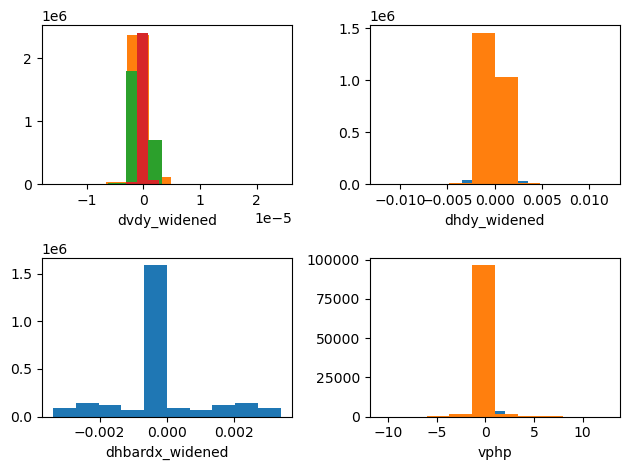

In [11]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [12]:
batch_xr.std()

<xarray.Dataset> Size: 80B
Dimensions:          ()
Data variables:
    dudx_widened     float64 8B 4.225e-07
    dvdx_widened     float64 8B 9.09e-07
    dudy_widened     float64 8B 6.408e-07
    dvdy_widened     float64 8B 4.242e-07
    dhdx_widened     float64 8B 0.0006591
    dhdy_widened     float64 8B 0.0007477
    dhbardx_widened  float64 8B 0.001261
    dhbardy_widened  float64 8B 0.0009414
    filter_scale     float64 8B 1.341e+05
    uphp             float32 4B 0.4053
    vphp             float32 4B 0.61

In [13]:
normalize_data_dic = {
    'dudx_widened': ([], 1e-7),  # scalar value
    'dvdx_widened': ([], 1e-7),
    'dudy_widened': ([], 1e-7),
    'dvdy_widened': ([], 1e-7),
    'dhdx_widened': ([], 1e-4),
    'dhdy_widened': ([], 1e-4),
    'dhbardx_widened': ([], 1e-3),
    'dhbardy_widened': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], .4),
    'vphp': ([], .4)}

ds_norm = xr.Dataset(normalize_data_dic)

In [14]:
wandb.config.update({"normalization_constants": normalize_data_dic})

In [15]:
# Define the variables and assign normalizations 

# normalize_data_dic = {
#     'dudx': ([], 1e-6),  # scalar value
#     'dvdx': ([], 1e-6),
#     'dudy': ([], 1e-6),
#     'dvdy': ([], 1e-6),
#     'dhdx': ([], 1e-3),
#     'dhdy': ([], 1e-3),
#     'dedx_middle': ([], 1e-3),
#     'dedy_middle': ([], 1e-3),
#     'filter_scale': ([], 140e3),
#     'uphp': ([], 4.),
#     'vphp': ([], 4.),

#     'dudx_nondim': ([], 1.),  # scalar value
#     'dvdx_nondim': ([], 1.),
#     'dudy_nondim': ([], 1.),
#     'dvdy_nondim': ([], 1.),
    
#     'uphp_nondim': ([], 1e-5),
#     'vphp_nondim': ([], 1e-5),

#     'dudx_widened': ([], 1e-6),  # scalar value
#     'dvdx_widened': ([], 1e-6),
#     'dudy_widened': ([], 1e-6),
#     'dvdy_widened': ([], 1e-6),
#     'dhdx_widened': ([], 1e-3),
#     'dhdy_widened': ([], 1e-3),
#     'dedx_middle_widened': ([], 1e-3),
#     'dedy_middle_widened': ([], 1e-3),
#     'dhdx_widened_rotated': ([], 1e-3),
#     'dhdy_widened_rotated': ([], 1e-3),
    
#     'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
#     'dvdx_widened_rotated_nondim': ([], 1e-1),
#     'dudy_widened_rotated_nondim': ([], 1e-1),
#     'dvdy_widened_rotated_nondim': ([], 1e-1),
#     'dhdx_widened_rotated_nondim': ([], 1e-1),
#     'dhdy_widened_rotated_nondim': ([], 1e-1),
#     'uphp_rotated_nondim': ([], 1e-5),
#     'vphp_rotated_nondim': ([], 1e-5),
# }

# ds_norm = xr.Dataset(normalize_data_dic)

In [16]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [17]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (100754, 201)
Output (y) batch shape: (100754, 2)


In [18]:
num_in = batch_out['X'].shape[-1]
num_in

201

In [19]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [20]:
ANN_model.count_parameters()

8678


In [21]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [ ]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=101, print_freq=2, use_wandb=True)

At epoch 1. Train loss :  1.5744957988326613 , Test loss: 1.057511043548584
At epoch 3. Train loss :  0.7763661758319752 , Test loss: 0.7610811948776245
At epoch 5. Train loss :  0.6235141818587845 , Test loss: 0.6475029706954956
At epoch 7. Train loss :  0.5782750619424356 , Test loss: 0.5958170652389526
At epoch 9. Train loss :  0.5231797920691 , Test loss: 0.5422486782073974
At epoch 11. Train loss :  0.48536208271980286 , Test loss: 0.5050989270210267
At epoch 13. Train loss :  0.46069359054436554 , Test loss: 0.4832715272903442
At epoch 15. Train loss :  0.44121378740748846 , Test loss: 0.45424460172653197
At epoch 17. Train loss :  0.41975911968463175 , Test loss: 0.45511614084243773
At epoch 19. Train loss :  0.4140928025181229 , Test loss: 0.42161070704460146
At epoch 21. Train loss :  0.3988725462475339 , Test loss: 0.4200186014175415
At epoch 23. Train loss :  0.3818239199148642 , Test loss: 0.4034306526184082
At epoch 25. Train loss :  0.36429811732189077 , Test loss: 0.3954

Clearly and obviously this loss is a function of the normalization that is used. 

In [ ]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

### Model evaluation 

In [ ]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])

In [ ]:
# Spin up eval pack
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()

In [ ]:
exp = experiment_config['simulation_names'][0]
var = experiment_config['output_channels'][0]

for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 7))
    
    vmin=-3.5
    zl_choice = 0
    
    plt.subplot(231)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 0')
    
    plt.subplot(232)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 0')
    
    plt.subplot(233)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 0')
    
    vmin=-1.2 
    zl_choice = 1
    
    plt.subplot(234)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 1')
    
    plt.subplot(235)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 1')
    
    plt.subplot(236)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 1')
    
    plt.suptitle(scale)
    plt.tight_layout()
    
    #wandb.Image(plt)
    #wandb.log({'chart':plt})
    
    # buf = io.BytesIO()
    # fig.savefig(buf, format='png')
    # buf.seek(0)
    
    # Log the figure to W&B
    plt_key = var+ '_panels_' + scale
    wandb.log({plt_key: wandb.Image(plt)})

In [ ]:
exp = experiment_config['simulation_names'][0]
var = experiment_config['output_channels'][1]

for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 7))
    
    vmin=-3.5
    zl_choice = 0
    
    plt.subplot(231)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 0')
    
    plt.subplot(232)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 0')
    
    plt.subplot(233)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 0')
    
    vmin=-1.2 
    zl_choice = 1
    
    plt.subplot(234)
    test_eval.eval_datatree.ml_dataset[exp][scale][var].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True, layer 1')
    
    plt.subplot(235)
    test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('Prediction, layer 1')
    
    plt.subplot(236)
    (test_eval.eval_datatree.ml_dataset[exp][scale][var] - 
     test_eval.eval_datatree.ml_dataset[exp][scale][var+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)
    plt.title('True - Prediction, layer 1')
    
    plt.suptitle(scale)
    plt.tight_layout()
    
    #wandb.Image(plt)
    #wandb.log({'chart':plt})
    
    # buf = io.BytesIO()
    # fig.savefig(buf, format='png')
    # buf.seek(0)
    
    # Log the figure to W&B
    plt_key = var+ '_panels_' + scale
    wandb.log({plt_key: wandb.Image(plt)})

In [ ]:
# Pick some region away from boundaries to do that stats 

In [ ]:
#test_eval.calc_time_hor_space_metrics(yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])
#test_eval.calc_time_hor_space_metrics(var='vphp',yh_region=slice(31, 45), xh_region=slice(5, 17), dims=['Time','xh','yh'])

In [ ]:
test_eval.calc_time_hor_space_metrics(var='uphp', descriptor='all_space_time', dims=['Time','xh','yh','zl'])
test_eval.calc_time_hor_space_metrics(var='vphp', descriptor='all_space_time', dims=['Time','xh','yh','zl'])

test_eval.calc_time_hor_space_metrics(var='uphp', descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp', descriptor='layer_wise', dims=['Time','xh','yh'])

In [ ]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values))

In [ ]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', corr for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_layer_wise.values))
        print(exp+' '+scale+', corr for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_layer_wise.values))

In [ ]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', MSE for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_layer_wise.values))
        print(exp+' '+scale+', MSE for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_layer_wise.values))

In [ ]:
## Write scalewise summary metrics into wandb 

R2_list = np.array([])
corr_list = np.array([])
mse_list = np.array([])

for scale in experiment_config['filter_scales']:

    mse = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_all_space_time.values)
    corr = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values)
    R2 = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values)
    
    wandb.run.summary['mse_'+scale] = mse
    wandb.run.summary['R2_'+scale] = R2
    wandb.run.summary['corr_'+scale] = corr
    R2_list = np.append(R2_list, R2)
    corr_list = np.append(corr_list, corr)
    mse_list = np.append(mse_list, mse)

wandb.run.summary['mse'] = np.mean(mse_list)
wandb.run.summary['R2'] = np.mean(R2_list)
wandb.run.summary['corr'] = np.mean(corr_list)

for scale in experiment_config['filter_scales']:
    wandb.run.summary['mse_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_layer_wise.values)
    wandb.run.summary['R2_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values)
    wandb.run.summary['corr_'+scale+'_layerwise'] = 0.5*(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_layer_wise.values + test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_layer_wise.values)
    

In [ ]:
wandb.finish()

Note that the MSE values here are a bit larger than what we had in loss. This is for 2 reasons (i) There is a factor of 4 in normalization, and (ii) we divided the MSE in training by 2 out of convention. 